<a href="https://colab.research.google.com/github/cjkreienkamp/machine-learning-notebooks/blob/main/01_tabular_data_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up environment

In [1]:
import sys

import torch
import cv2
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Data preparation

In [3]:
import zipfile
import os
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"chriskreienkamp","key":"ff72bdc10e9c9734ff00aa6a0f45f998"}'}

In [4]:
### DOWNLOAD DATA

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c titanic
with zipfile.ZipFile("titanic.zip", "r") as z:
    z.extractall("titanic")

# List extracted files
os.listdir("titanic")

  0% 0.00/34.1k [00:00<?, ?B/s]
100% 34.1k/34.1k [00:00<00:00, 47.2MB/s]


['gender_submission.csv', 'train.csv', 'test.csv']

In [5]:
### ORGANIZE DATA

raw_train_df = pd.read_csv("titanic/train.csv")
raw_test_df = pd.read_csv("titanic/test.csv")

# Display the first few rows
print(raw_train_df.info())
raw_train_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
X_train, X_valid = train_test_split(raw_train_df, test_size=0.25, shuffle=True)

In [7]:
from torch.utils.data import Dataset, DataLoader

In [8]:
class TitanicDataset(Dataset):
    def __init__(self, df):

        df['LogFare'] = np.log1p(df['Fare'])
        df['DeckGroup'] = df['Cabin'].str[0].map({'A': 'ABC', 'B': 'ABC', 'C':'ABC', 'D':'DE', 'E': 'DE', 'F': 'FG', 'G': 'FG'})
        df['Family'] = df['SibSp'] + df['Parch']
        df['Alone'] = (df['Family'] == 0).map({True: 1, False: 0})
        df['TicketFreq'] = df.groupby('Ticket')['Ticket'].transform('count')
        df['Title'] = df['Name'].str.split(', ', expand=True).iloc[:, 1].str.split('.', expand=True).iloc[:, 0]
        df['Title'] = df['Title'].map({'Mr': 'Mr', 'Miss': 'Miss', 'Mrs': 'Mrs', 'Master': 'Master'})
        df['Sex'] = df['Sex'].map({'male': 1, 'female': 0})

        df = df.drop(['Name', 'Ticket', 'Cabin', 'PassengerId', 'Fare', 'SibSp', 'Parch'], axis=1)

        train_modes = df.mode().iloc[0]
        df = df.fillna(train_modes)

        df['Age'] = (df['Age'] - df['Age'].min()) / (df['Age'].max() - df['Age'].min())

        df = pd.get_dummies(df, columns=['Pclass', 'Embarked', 'DeckGroup', 'Title'])

        self.X = df.drop('Survived', axis=1).values.astype(np.float32)
        self.y = df['Survived'].values.astype(np.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        return torch.tensor(self.X[index]), torch.tensor(self.y[index])

In [9]:
train_dataset = TitanicDataset(X_train)
valid_dataset = TitanicDataset(X_valid)

In [24]:
torch.manual_seed(42)
train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=len(valid_dataset), shuffle=False)

In [25]:
for x, y in train_loader:
    print(x.shape, y.shape)
    break

for x1, y1 in valid_loader:
    print(x1.shape, y1.shape)
    break

print(len(train_loader), len(valid_loader))

torch.Size([668, 19]) torch.Size([668])
torch.Size([223, 19]) torch.Size([223])
1 1


# Model training

In [26]:
import torch.nn as nn
from torchsummary import summary

In [27]:
class TitanicModel(nn.Module):
    def __init__(self):
        super(TitanicModel, self).__init__()
        input_size = 19
        self.fc1 = nn.Linear(input_size, out_features=64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        for _ in range(15):
            x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

print(f"Input size: {x.shape}")
summary(TitanicModel(), x.shape)

Input size: torch.Size([668, 19])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 668, 64]           1,280
            Linear-2              [-1, 668, 64]           4,160
            Linear-3              [-1, 668, 64]           4,160
            Linear-4              [-1, 668, 64]           4,160
            Linear-5              [-1, 668, 64]           4,160
            Linear-6              [-1, 668, 64]           4,160
            Linear-7              [-1, 668, 64]           4,160
            Linear-8              [-1, 668, 64]           4,160
            Linear-9              [-1, 668, 64]           4,160
           Linear-10              [-1, 668, 64]           4,160
           Linear-11              [-1, 668, 64]           4,160
           Linear-12              [-1, 668, 64]           4,160
           Linear-13              [-1, 668, 64]           4,160
     

In [20]:
class TitanicModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(19, 64)
        self.linear2 = nn.Linear(64, 128)
        self.linear3 = nn.Linear(128, 96)
        self.linear4 = nn.Linear(96, 32)
        self.linear5 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.25)
    def forward(self, x):
        return self.linear5(self.relu(self.linear4(self.dropout(self.relu(self.linear3(self.dropout(self.relu(self.linear2(self.dropout(self.relu(self.linear1(x))))))))))))

print(f"Input size: {x.shape}")
summary(TitanicModel(), x.shape)

Input size: torch.Size([128, 19])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 128, 64]           1,280
              ReLU-2              [-1, 128, 64]               0
           Dropout-3              [-1, 128, 64]               0
            Linear-4             [-1, 128, 128]           8,320
              ReLU-5             [-1, 128, 128]               0
           Dropout-6             [-1, 128, 128]               0
            Linear-7              [-1, 128, 96]          12,384
              ReLU-8              [-1, 128, 96]               0
           Dropout-9              [-1, 128, 96]               0
           Linear-10              [-1, 128, 32]           3,104
             ReLU-11              [-1, 128, 32]               0
           Linear-12               [-1, 128, 1]              33
Total params: 25,121
Trainable params: 25,121
Non-trainable params: 0

In [28]:
def train_fn(data_loader, model, optimizer):

    total_loss, total_correct, total_samples = 0.0, 0, 0

    model.train()

    for X, y in data_loader:

        X = X.to(DEVICE)
        y = y.to(DEVICE)

        logits = model(X).squeeze()
        predictions = torch.round(torch.sigmoid(logits))

        loss = loss_fn(logits, y)
        total_loss += loss.item()
        total_correct += (predictions == y).sum().item()
        total_samples += len(y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return total_loss / len(data_loader) , total_correct / total_samples * 100

def eval_fn(data_loader, model):

    total_loss, total_correct, total_samples = 0.0, 0, 0

    model.eval()

    with torch.inference_mode():

        for X, y in data_loader:

            X = X.to(DEVICE)
            y = y.to(DEVICE)

            logits = model(X).squeeze()
            predictions = torch.round(torch.sigmoid(logits))

            loss = loss_fn(logits, y)
            total_loss += loss.item()
            total_correct += (predictions == y).sum().item()
            total_samples += len(y)

        return total_loss / len(data_loader), total_correct / total_samples * 100

In [37]:
EPOCHS = 1500
LEARNING_RATE = 0.0001
L2_REG = 1e-4

loss_fn = nn.BCEWithLogitsLoss()

In [38]:
model = TitanicModel().to(DEVICE)
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE, weight_decay=L2_REG)

epoch_count, train_loss_values, valid_loss_values = [], [], []
train_acc_values, valid_acc_values = [], []
best_valid_loss = np.Inf

for epoch in range(EPOCHS):

    train_loss, train_accuracy = train_fn(train_loader, model, optimizer)
    valid_loss, valid_accuracy = eval_fn(valid_loader, model)

    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'best_model.pth')
        best_valid_loss = valid_loss

    if epoch % int(EPOCHS / 20) == 0:
        print(f'Epoch: {epoch:4.0f} | Train Loss: {train_loss:.5f}, Accuracy: {train_accuracy:.2f}% | Validation Loss: {valid_loss:.5f}, Accuracy: {valid_accuracy:.2f}%')
        epoch_count.append(epoch)
        train_loss_values.append(train_loss)
        valid_loss_values.append(valid_loss)
        train_acc_values.append(train_accuracy)
        valid_acc_values.append(valid_accuracy)


Epoch:    0 | Train Loss: 0.70074, Accuracy: 37.13% | Validation Loss: 0.69783, Accuracy: 42.15%
Epoch:   75 | Train Loss: 0.68997, Accuracy: 62.87% | Validation Loss: 0.69115, Accuracy: 57.85%
Epoch:  150 | Train Loss: 0.67510, Accuracy: 62.87% | Validation Loss: 0.68341, Accuracy: 57.85%
Epoch:  225 | Train Loss: 0.65831, Accuracy: 62.87% | Validation Loss: 0.68829, Accuracy: 57.85%
Epoch:  300 | Train Loss: 0.59265, Accuracy: 62.87% | Validation Loss: 0.63442, Accuracy: 57.85%
Epoch:  375 | Train Loss: 0.48447, Accuracy: 82.78% | Validation Loss: 0.52464, Accuracy: 81.17%
Epoch:  450 | Train Loss: 0.46071, Accuracy: 82.63% | Validation Loss: 0.50483, Accuracy: 80.72%
Epoch:  525 | Train Loss: 0.41056, Accuracy: 83.53% | Validation Loss: 0.46516, Accuracy: 80.72%
Epoch:  600 | Train Loss: 0.38792, Accuracy: 83.83% | Validation Loss: 0.44997, Accuracy: 81.17%
Epoch:  675 | Train Loss: 0.34492, Accuracy: 85.63% | Validation Loss: 0.47485, Accuracy: 82.51%
Epoch:  750 | Train Loss: 0.32

# Model evaluation

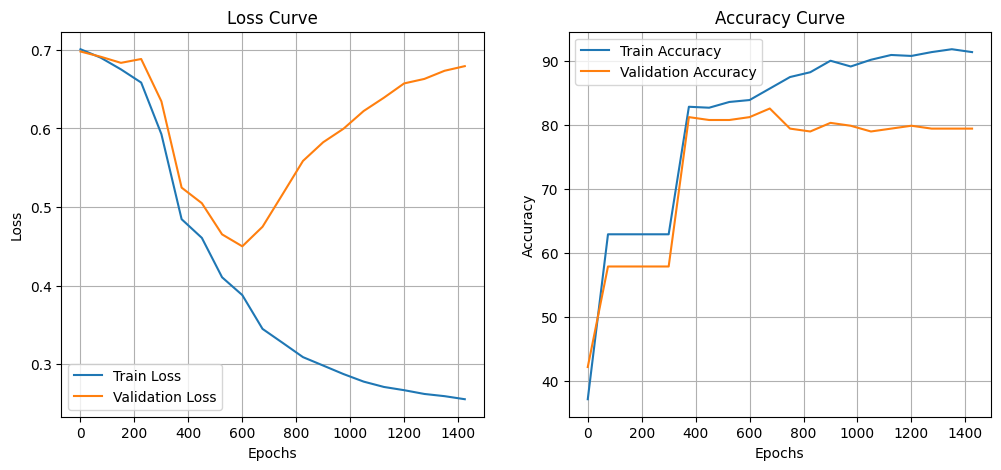

In [39]:
import matplotlib.pyplot as plt

def plot_loss_accuracy(epoch_count, train_loss_values, train_acc_values, valid_loss_values, valid_acc_values):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Plot Loss Curve
    axes[0].plot(epoch_count, train_loss_values, label='Train Loss')
    axes[0].plot(epoch_count, valid_loss_values, label='Validation Loss')
    axes[0].set_title('Loss Curve')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)

    # Plot Accuracy Curve
    axes[1].plot(epoch_count, train_acc_values, label='Train Accuracy')
    axes[1].plot(epoch_count, valid_acc_values, label='Validation Accuracy')
    axes[1].set_title('Accuracy Curve')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True)

    plt.show()

# Example Usage
plot_loss_accuracy(epoch_count, train_loss_values, train_acc_values, valid_loss_values, valid_acc_values)

In [41]:
from pathlib import Path

In [42]:
# Create a directory for models
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Create a model save path
MODEL_NAME = 'pytorch_model.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)


In [43]:
for x_test, y_test in valid_loader:
    print(x_test.shape, y_test.shape)
    break

torch.Size([223, 19]) torch.Size([223])


In [44]:
model.eval()

with torch.inference_mode():
    test_logits = model(x_test.to(DEVICE)).squeeze()
    test_predictions = torch.round(torch.sigmoid(test_logits)).int()

In [45]:
y_test.int(), test_predictions

(tensor([0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0,
         1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
         0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
         0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0,
         1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1,
         0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
         0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1,
         0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
         1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0,
         0, 0, 0, 0, 0, 0, 1], dtype=torch.int32),
 tensor([0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0,
         1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0,
         0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0